In [1]:
import pandas as pd
import datetime
import glob
from minio import Minio
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
client = Minio(
        "localhost:9000",
        access_key="minioadmin",
        secret_key="minioadmin",
        secure=False
    )

### Baixando o Dataset do Data Lake.

In [3]:
client.fget_object(
            "processing",
            "employeesDataset.parquet",
            "temp_.parquet",
)
df = pd.read_parquet("temp_.parquet")
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerName,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,Michael Albert,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,Simon Roup,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,Kissy Sullivan,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,Elijiah Gray,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,Webster Butler,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2


Criar um atributo targuet binário para os funcionários com boas peformances e satisfeitos com boa satisfação


In [4]:
def perfScoreSatisfaction(x):
    if (x['PerformanceScore'] == 'Fully Meets' or x['PerformanceScore'] == 'Needs Improvement') and (x['EmpSatisfaction'] == 3 or x['EmpSatisfaction'] == 4 or x['EmpSatisfaction'] == 5) and x['Termd'] == 0:
        return True
    else:
        return False

In [5]:
df['PerfScoreSatisfaction'] = df[['PerformanceScore', 'EmpSatisfaction', 'Termd']].apply(lambda x: perfScoreSatisfaction(x), axis=1)
df.head()

,Employee_Name,EmpID,MarriedID,MaritalStatusID,GenderID,EmpStatusID,DeptID,PerfScoreID,FromDiversityJobFairID,Salary,...,ManagerID,RecruitmentSource,PerformanceScore,EngagementSurvey,EmpSatisfaction,SpecialProjectsCount,LastPerformanceReview_Date,DaysLateLast30,Absences,PerfScoreSatisfaction
0,"Adinolfi, Wilson K",10026,0,0,1,1,5,4,0,62506,...,22.0,LinkedIn,Exceeds,4.60,5,0,1/17/2019,0,1,False
1,"Ait Sidi, Karthikeyan",10084,1,1,1,5,3,3,0,104437,...,4.0,Indeed,Fully Meets,4.96,3,6,2/24/2016,0,17,False
2,"Akinkuolie, Sarah",10196,1,1,0,5,5,3,0,64955,...,20.0,LinkedIn,Fully Meets,3.02,3,0,5/15/2012,0,3,False
3,"Alagbe,Trina",10088,1,1,0,1,5,3,0,64991,...,16.0,Indeed,Fully Meets,4.84,5,0,1/3/2019,0,15,True
4,"Anderson, Carol",10069,0,2,0,5,5,3,0,50825,...,39.0,Google Search,Fully Meets,5.00,4,0,2/1/2016,0,2,False


#### separando features

In [6]:
df = df[['Department', 'Salary', 'DaysLateLast30',
       'SpecialProjectsCount', 'EmpSatisfaction', 'PerformanceScore',
       'EngagementSurvey', 'Absences','Termd', 'FromDiversityJobFairID', 
       'Position', 'Sex', 'MaritalDesc', 'CitizenDesc', 'HispanicLatino', 'RaceDesc', 
       'TermReason', 'EmploymentStatus',
       'RecruitmentSource', 'PerfScoreID', 'PerfScoreSatisfaction']]

df.head()

,Department,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,PerformanceScore,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,...,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,TermReason,EmploymentStatus,RecruitmentSource,PerfScoreID,PerfScoreSatisfaction
0,Production,62506,0,0,5,Exceeds,4.60,1,0,0,...,M,Single,US Citizen,No,White,N/A-StillEmployed,Active,LinkedIn,4,False
1,IT/IS,104437,0,6,3,Fully Meets,4.96,17,1,0,...,M,Married,US Citizen,No,White,career change,Voluntarily Terminated,Indeed,3,False
2,Production,64955,0,0,3,Fully Meets,3.02,3,1,0,...,F,Married,US Citizen,No,White,hours,Voluntarily Terminated,LinkedIn,3,False
3,Production,64991,0,0,5,Fully Meets,4.84,15,0,0,...,F,Married,US Citizen,No,White,N/A-StillEmployed,Active,Indeed,3,True
4,Production,50825,0,0,4,Fully Meets,5.00,2,1,0,...,F,Divorced,US Citizen,No,White,return to school,Voluntarily Terminated,Google Search,3,False


#### Verificando os registros missing.

In [7]:
df.isnull().sum()

Department                0
Salary                    0
DaysLateLast30            0
SpecialProjectsCount      0
EmpSatisfaction           0
PerformanceScore          0
EngagementSurvey          0
Absences                  0
Termd                     0
FromDiversityJobFairID    0
Position                  0
Sex                       0
MaritalDesc               0
CitizenDesc               0
HispanicLatino            0
RaceDesc                  0
TermReason                0
EmploymentStatus          0
RecruitmentSource         0
PerfScoreID               0
PerfScoreSatisfaction     0
dtype: int64

In [8]:
df[df.notnull()]

,Department,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,PerformanceScore,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,...,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,TermReason,EmploymentStatus,RecruitmentSource,PerfScoreID,PerfScoreSatisfaction
0,Production,62506,0,0,5,Exceeds,4.60,1,0,0,...,M,Single,US Citizen,No,White,N/A-StillEmployed,Active,LinkedIn,4,False
1,IT/IS,104437,0,6,3,Fully Meets,4.96,17,1,0,...,M,Married,US Citizen,No,White,career change,Voluntarily Terminated,Indeed,3,False
2,Production,64955,0,0,3,Fully Meets,3.02,3,1,0,...,F,Married,US Citizen,No,White,hours,Voluntarily Terminated,LinkedIn,3,False
3,Production,64991,0,0,5,Fully Meets,4.84,15,0,0,...,F,Married,US Citizen,No,White,N/A-StillEmployed,Active,Indeed,3,True
4,Production,50825,0,0,4,Fully Meets,5.00,2,1,0,...,F,Divorced,US Citizen,No,White,return to school,Voluntarily Terminated,Google Search,3,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306,Production,65893,0,0,4,Fully Meets,4.07,13,0,0,...,M,Single,US Citizen,No,White,N/A-StillEmployed,Active,LinkedIn,3,True
307,Production,48513,5,0,2,PIP,3.20,4,1,0,...,F,Single,US Citizen,No,Asian,Another position,Voluntarily Terminated,Google Search,1,False
308,IT/IS,220450,0,6,5,Exceeds,4.60,16,0,0,...,F,Single,US Citizen,No,White,N/A-StillEmployed,Active,Employee Referral,4,False
309,IT/IS,89292,0,5,3,Fully Meets,5.00,11,0,0,...,F,Single,US Citizen,No,White,N/A-StillEmployed,Active,Employee Referral,3,True


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Department              311 non-null    object 
 1   Salary                  311 non-null    int64  
 2   DaysLateLast30          311 non-null    int64  
 3   SpecialProjectsCount    311 non-null    int64  
 4   EmpSatisfaction         311 non-null    int64  
 5   PerformanceScore        311 non-null    object 
 6   EngagementSurvey        311 non-null    float64
 7   Absences                311 non-null    int64  
 8   Termd                   311 non-null    int64  
 9   FromDiversityJobFairID  311 non-null    int64  
 10  Position                311 non-null    object 
 11  Sex                     311 non-null    object 
 12  MaritalDesc             311 non-null    object 
 13  CitizenDesc             311 non-null    object 
 14  HispanicLatino          311 non-null    ob

##  Análise Estatística

#### Verificando o número de registros.

In [10]:
df.shape

(311, 21)

In [11]:
df.head()

,Department,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,PerformanceScore,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,...,Sex,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,TermReason,EmploymentStatus,RecruitmentSource,PerfScoreID,PerfScoreSatisfaction
0,Production,62506,0,0,5,Exceeds,4.60,1,0,0,...,M,Single,US Citizen,No,White,N/A-StillEmployed,Active,LinkedIn,4,False
1,IT/IS,104437,0,6,3,Fully Meets,4.96,17,1,0,...,M,Married,US Citizen,No,White,career change,Voluntarily Terminated,Indeed,3,False
2,Production,64955,0,0,3,Fully Meets,3.02,3,1,0,...,F,Married,US Citizen,No,White,hours,Voluntarily Terminated,LinkedIn,3,False
3,Production,64991,0,0,5,Fully Meets,4.84,15,0,0,...,F,Married,US Citizen,No,White,N/A-StillEmployed,Active,Indeed,3,True
4,Production,50825,0,0,4,Fully Meets,5.00,2,1,0,...,F,Divorced,US Citizen,No,White,return to school,Voluntarily Terminated,Google Search,3,False


#### Calculando a taxas

In [12]:
# taxa de PerfScoreSatisfaction
perfScoreSatisfactionRate = df.PerfScoreSatisfaction.value_counts() / len(df)
perfScoreSatisfactionRate

True     0.540193
False    0.459807
Name: PerfScoreSatisfaction, dtype: float64

In [13]:
# taxa de turnover
turnoverRate = df.Termd.value_counts() / len(df)
turnoverRate

0    0.665595
1    0.334405
Name: Termd, dtype: float64

OBS: os dados estão desnalenceados para Termd

In [14]:
# taxa de Sex
sexrRate = df.Sex.value_counts() / len(df)
sexrRate

F     0.565916
M     0.434084
Name: Sex, dtype: float64

In [15]:
# taxa de MaritalDesc
maritalDescRate = df.MaritalDesc.value_counts() / len(df)
maritalDescRate

Single       0.440514
Married      0.398714
Divorced     0.096463
Separated    0.038585
Widowed      0.025723
Name: MaritalDesc, dtype: float64

In [16]:
# taxa de PerformanceScore
performanceScoreRate = df.PerformanceScore.value_counts() / len(df)
performanceScoreRate

Fully Meets          0.781350
Exceeds              0.118971
Needs Improvement    0.057878
PIP                  0.041801
Name: PerformanceScore, dtype: float64

performance desbalanceada

In [17]:
# taxa de EmpSatisfaction
empSatisfaction = df.EmpSatisfaction.value_counts() / len(df)
empSatisfaction

3    0.347267
5    0.315113
4    0.302251
2    0.028939
1    0.006431
Name: EmpSatisfaction, dtype: float64

nemos um leve balanceamento para EmpSatisfaction entre 3, 4, 5

In [18]:
# taxa de EmploymentStatus
employmentStatusRate = df.EmploymentStatus.value_counts() / len(df)
employmentStatusRate

Active                    0.665595
Voluntarily Terminated    0.282958
Terminated for Cause      0.051447
Name: EmploymentStatus, dtype: float64

#### Overview estatistico dos dados.

In [19]:
df.describe()

,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,PerfScoreID
count,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000,311.000000
mean,69020.684887,0.414791,1.218650,3.890675,4.110000,10.237942,0.334405,0.093248,2.977492
std,25156.636930,1.294519,2.349421,0.909241,0.789938,5.852596,0.472542,0.291248,0.587072
min,45046.000000,0.000000,0.000000,1.000000,1.120000,1.000000,0.000000,0.000000,1.000000
25%,55501.500000,0.000000,0.000000,3.000000,3.690000,5.000000,0.000000,0.000000,3.000000
50%,62810.000000,0.000000,0.000000,4.000000,4.280000,10.000000,0.000000,0.000000,3.000000
75%,72036.000000,0.000000,0.000000,5.000000,4.700000,15.000000,1.000000,0.000000,3.000000
max,250000.000000,6.000000,8.000000,5.000000,5.000000,20.000000,1.000000,1.000000,4.000000


In [20]:
df.shape

(311, 21)

Medias 
- salario médio de 69.020 por ano
- satisfação média 3.8 com desvio de 0.9, minimo de 1, escala de 0 à 4
- engajamento médio 4.1 com desvio de 0.7 minimo de 1.1. escala de 0 á 5.
- taxa de 54% com performance satisfeitos.
é uma empresa que avalia bem seus funcionarios e tem uma avaliação de satisfação um pouco maior



#### Overview statistico por PerformanceScore.

In [21]:
performanceScoreSummary = df.groupby('PerfScoreSatisfaction')
performanceScoreSummary.mean()

,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,PerfScoreID
PerfScoreSatisfaction,,,,,,,,,
False,68428.608392,0.727273,0.888112,3.804196,4.043846,10.664336,0.727273,0.146853,3.013986
True,69524.654762,0.148810,1.500000,3.964286,4.166310,9.875000,0.000000,0.047619,2.946429


O dataset tem:

- 311 observações de funcionários e 21 atributos.
- A empresa tem uma rotatividade de 33%.
- A satisfação média dos funcionários que deixaram a empresa é 3,8 equiparada aos que ficaram
- o atraso fez mais diferença entre os funcionários mais engajados e que avaliaram bem a empresa

#### Calculando a matriz de correlação.

,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,PerfScoreID,PerfScoreSatisfaction
Salary,1.000000,-0.069443,0.508333,0.062718,0.064966,0.082382,-0.093994,0.041248,0.130903,0.021749
DaysLateLast30,-0.069443,1.000000,-0.092494,-0.235412,-0.585232,0.001833,0.136379,0.042532,-0.734728,-0.223064
SpecialProjectsCount,0.508333,-0.092494,1.000000,0.033877,0.013227,-0.020452,-0.147429,0.031393,0.045677,0.130009
EmpSatisfaction,0.062718,-0.235412,0.033877,1.000000,0.187105,0.075222,-0.004732,-0.034468,0.303579,0.087891
EngagementSurvey,0.064966,-0.585232,0.013227,0.187105,1.000000,-0.008771,-0.017543,-0.013040,0.544927,0.077388
Absences,0.082382,0.001833,-0.020452,0.075222,-0.008771,1.000000,0.098274,0.062640,0.046629,-0.067325
Termd,-0.093994,0.136379,-0.147429,-0.004732,-0.017543,0.098274,1.000000,0.147717,-0.089061,-0.768278
FromDiversityJobFairID,0.041248,0.042532,0.031393,-0.034468,-0.013040,0.062640,0.147717,1.000000,0.012315,-0.170083
PerfScoreID,0.130903,-0.734728,0.045677,0.303579,0.544927,0.046629,-0.089061,0.012315,1.000000,-0.057444
PerfScoreSatisfaction,0.021749,-0.223064,0.130009,0.087891,0.077388,-0.067325,-0.768278,-0.170083,-0.057444,1.000000


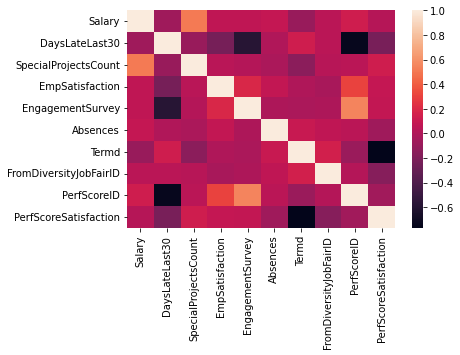

In [22]:
corr = df.corr()
corr = (corr)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

corr

###  Correlation Matrix & Heatmap
***
**Atributos com uma correlação moderada positiva:** 
- SpecialProjectsCount vs Salary: 0.50
- EngagementSurvey vs PerfScoreID: 0.54
- PerfScoreID vs EmpSatisfaction: 0.30

**Atributos com uma correlação moderada negativa:**
 - DaysLateLast30 vs PerfScoreID:  -0.73
 - EngagementSurvey vs DaysLateLast30: -0.58
 - DaysLateLast30 vs PerfScoreSatisfaction: -0.22
 - PerfScoreSatisfaction vs Termd: -0.76

**Questões:**
- Quais atributos afetam nossa variável alvo (PerfScoreSatisfaction)?
- Existem atributos com alta correlação entre eles?
- Como podemos aprofundar para entender as correlações?

**Resumo:**

Existe uma **correlação positiva** entre os atributos SpecialProjectsCount e Salary.

Faz sentido que funionários que estão envolvidos em mais projetos, tem maiores ganhos.

A correlação de PerfScoreID vs EmpSatisfaction é menor mas represantativa para sugerir que os mais satisfeitos são bem avaliados.

Outra **correlação positiva** é entre EngagementSurvey e PerfScoreID, o que indica que os funcionários mais bem avaliados na empresa são mais engajados.

Existe uma **correlação negativa** entre os atributos DaysLateLast30 e PerfScoreID.

Outra **correlação negativa** forte é entre EngagementSurvey e DaysLateLast30

outra **correlação negativa** muito forte é PerfScoreSatisfaction vs Termd com uma relativa DaysLateLast30 vs PerfScoreSatisfaction.
Os atrasos nos ultimos 30 dias podem ser um idicativo de insadisfação e consequente termino de contrato. Vale a pena uma intervenção nesse momento.

Podemos assumir que funcionários que mais atrazaram dos ultimos 30 dias estão com o score baixo e consequentemente são fracamente engajados

#### Calculando distribuições dos atributos.

In [23]:
client.fget_object(
            "processing",
            "employeePerformanceEvaluation.parquet",
            "temp_.parquet",
)
dfemployeePerformanceEvaluation = pd.read_parquet("temp_.parquet")
dfemployeePerformanceEvaluation.head()

,EmpID,EmpSatisfaction,PerfScoreID,PerformanceScore,EngagementSurvey,perfScoreSatisfaction
0,10026,5,4,Exceeds,4.60,False
1,10084,3,3,Fully Meets,4.96,False
2,10196,3,3,Fully Meets,3.02,False
3,10088,5,3,Fully Meets,4.84,True
4,10069,4,3,Fully Meets,5.00,False


/Users/san/Documents/GitHub/Artigo_PUCRS_CD_IA/venv/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


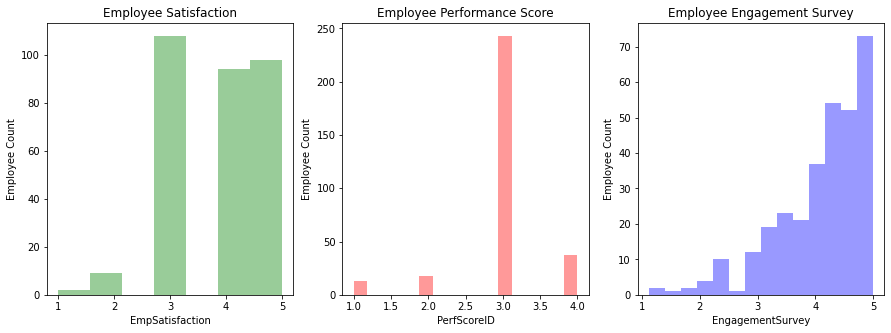

In [24]:
f, axes = plt.subplots(ncols=3, figsize=(15, 5))

sns.distplot(dfemployeePerformanceEvaluation.EmpSatisfaction, kde=False, color="g", ax=axes[0]).set_title('Employee Satisfaction')
axes[0].set_ylabel('Employee Count')

sns.distplot(dfemployeePerformanceEvaluation.PerfScoreID, kde=False, color="r", ax=axes[1]).set_title('Employee Performance Score')
axes[1].set_ylabel('Employee Count')

sns.distplot(dfemployeePerformanceEvaluation.EngagementSurvey, kde=False, color="b", ax=axes[2]).set_title('Employee Engagement Survey')
axes[2].set_ylabel('Employee Count')

plt.show()

In [25]:
dfemployeePerformanceEvaluation.describe()


,EmpID,EmpSatisfaction,PerfScoreID,EngagementSurvey
count,311.000000,311.000000,311.000000,311.000000
mean,10156.000000,3.890675,2.977492,4.110000
std,89.922189,0.909241,0.587072,0.789938
min,10001.000000,1.000000,1.000000,1.120000
25%,10078.500000,3.000000,3.000000,3.690000
50%,10156.000000,4.000000,3.000000,4.280000
75%,10233.500000,5.000000,3.000000,4.700000
max,10311.000000,5.000000,4.000000,5.000000


## Distribuições (EmpSatisfaction - PerfScoreID - EngagementSurvey)
***
**Summary:** Examinando a distribuição de alguns atributos do conjunto de dados:
 - **EmpSatisfaction** - Com base na Escala Likert, existe um pico de funcionários satisfeitos com a empresa. Porem, a maioria que avaliou estar muito satisfeito entre 4 a 5.
 - **PerfScoreID** - Temos uma concentração da avaliação dos funcionários em 3.0 bem proximo da média, poucos funcionários abaixo de 3.
 - **EngagementSurvey** - A concentração de funcionários é acima de 4. Sendo distribuição assimétrica à direita
 
**Questões:** 
 - Existe uma razão para um cenário otimista para a empresa e os funcionários?

#### Relação entre PerfScoreID e Salary

In [26]:
client.fget_object(
            "processing",
            "departmentSalaryTermd.parquet",
            "temp_.parquet",
)
dfSalary = pd.read_parquet("temp_.parquet")
dfSalary.head()

,EmpID,Department,Salary,Termd,SalaryLevel
0,10026,Production,62506,0,medium
1,10084,IT/IS,104437,1,high
2,10196,Production,64955,1,medium
3,10088,Production,64991,0,medium
4,10069,Production,50825,1,low


In [27]:
dfEmployeeSalaryPerfScore = pd.concat([dfSalary[["SalaryLevel"]],dfemployeePerformanceEvaluation[["PerfScoreID"]]], axis=1, join="inner")
employeeSalaryPerfScore = dfEmployeeSalaryPerfScore.groupby(["SalaryLevel", "PerfScoreID"])["PerfScoreID"].count()
employeeSalaryPerfScore

SalaryLevel  PerfScoreID
high         2                4
             3               61
             4               13
low          1                4
             2                5
             3               61
             4                8
medium       1                9
             2                9
             3              121
             4               16
Name: PerfScoreID, dtype: int64

In [28]:
dfEmployeeSalaryPerfScore = pd.concat([dfSalary[["SalaryLevel"]],dfemployeePerformanceEvaluation[["PerfScoreID"]]], axis=1, join="inner")
employeeSalaryPerfScoreResume = dfEmployeeSalaryPerfScore.groupby(["SalaryLevel"])["PerfScoreID"].count()
employeeSalaryPerfScoreResume

SalaryLevel
high       78
low        78
medium    155
Name: PerfScoreID, dtype: int64

In [29]:
mediumRatePerfScore = 155 / len(df)
mediumRatePerfScore

0.4983922829581994

In [30]:
highRatePerfScore = 78 / len(df)
highRatePerfScore

0.2508038585209003

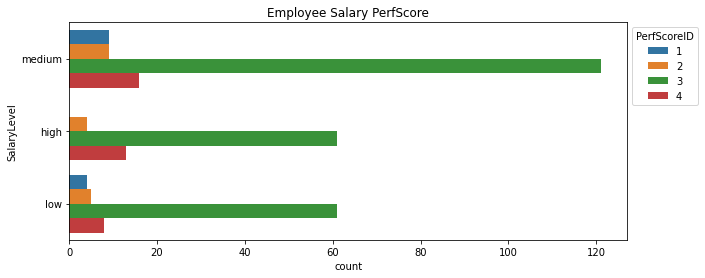

In [31]:
f, ax = plt.subplots(figsize=(10, 4))
sns.countplot(y='SalaryLevel', hue='PerfScoreID', data=dfEmployeeSalaryPerfScore).set_title('Employee Salary PerfScore')
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerfScoreID')

In [32]:
dfEngagementSurvey = pd.concat([df, dfSalary[['SalaryLevel']]], axis=1, join="inner")
dfEngagementSurvey.head()

,Department,Salary,DaysLateLast30,SpecialProjectsCount,EmpSatisfaction,PerformanceScore,EngagementSurvey,Absences,Termd,FromDiversityJobFairID,...,MaritalDesc,CitizenDesc,HispanicLatino,RaceDesc,TermReason,EmploymentStatus,RecruitmentSource,PerfScoreID,PerfScoreSatisfaction,SalaryLevel
0,Production,62506,0,0,5,Exceeds,4.60,1,0,0,...,Single,US Citizen,No,White,N/A-StillEmployed,Active,LinkedIn,4,False,medium
1,IT/IS,104437,0,6,3,Fully Meets,4.96,17,1,0,...,Married,US Citizen,No,White,career change,Voluntarily Terminated,Indeed,3,False,high
2,Production,64955,0,0,3,Fully Meets,3.02,3,1,0,...,Married,US Citizen,No,White,hours,Voluntarily Terminated,LinkedIn,3,False,medium
3,Production,64991,0,0,5,Fully Meets,4.84,15,0,0,...,Married,US Citizen,No,White,N/A-StillEmployed,Active,Indeed,3,True,medium
4,Production,50825,0,0,4,Fully Meets,5.00,2,1,0,...,Divorced,US Citizen,No,White,return to school,Voluntarily Terminated,Google Search,3,False,low


In [33]:
employeeSalaryPerfScore

SalaryLevel  PerfScoreID
high         2                4
             3               61
             4               13
low          1                4
             2                5
             3               61
             4                8
medium       1                9
             2                9
             3              121
             4               16
Name: PerfScoreID, dtype: int64

##  Salary V.S. PerformanceScore
***
**Summary:** This is not unusual. Here's what I found:
 - A maioria dos funcionários que saíram tinha salário **médio**.
 - Poucos funcionários com alto salário deixaram a empresa.
 
**Questões:** 
 - Como é o ambiente de trabalho? Isso se difere por salário?
 - O que faz 7% dos funcionários com alto salário sairem da empresa?

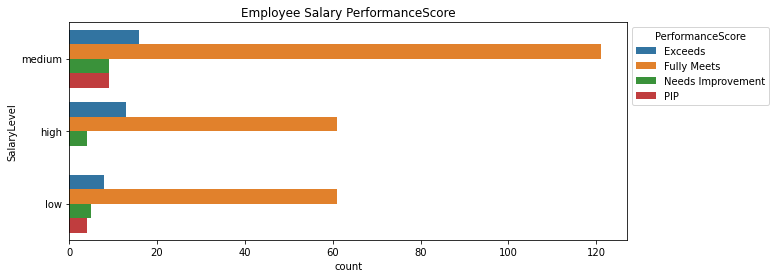

In [34]:
f, ax = plt.subplots(figsize=(10, 4))
sns.countplot(y="SalaryLevel", hue='PerformanceScore', data=dfEngagementSurvey).set_title('Employee Salary PerformanceScore');
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerformanceScore')

In [35]:
salaryLevelPerformanceScore = dfEngagementSurvey.groupby(["SalaryLevel", "PerformanceScore"])["PerformanceScore"].count()
salaryLevelPerformanceScore

SalaryLevel  PerformanceScore 
high         Exceeds               13
             Fully Meets           61
             Needs Improvement      4
low          Exceeds                8
             Fully Meets           61
             Needs Improvement      5
             PIP                    4
medium       Exceeds               16
             Fully Meets          121
             Needs Improvement      9
             PIP                    9
Name: PerformanceScore, dtype: int64

In [36]:
salaryLevelPerformanceScoreResume = dfEngagementSurvey.groupby(["SalaryLevel"])["PerformanceScore"].count()
salaryLevelPerformanceScoreResume

SalaryLevel
high       78
low        78
medium    155
Name: PerformanceScore, dtype: int64

Obs: 

- o maior número de funcionários, 121 funcionários foram avaliados que atendem totalmente como engajados e tem salário mediano. 
- 61 funcionários com altos salários foram declarados que atendem totalmente como engajados
- Os mais engajados foram 13 funcionários com salario alto, 16 com salário médio e 8 com salário baixo.
- Importante salientar os que tinha salario baixo, 4 funcionários foram avaliados com engajameno abaixo das expectativas.
- O nivel de salário médio é predominante na empresa, sendo 155 funcionarios, 50%


#### Verificando o PerformanceScore em relação departamento.

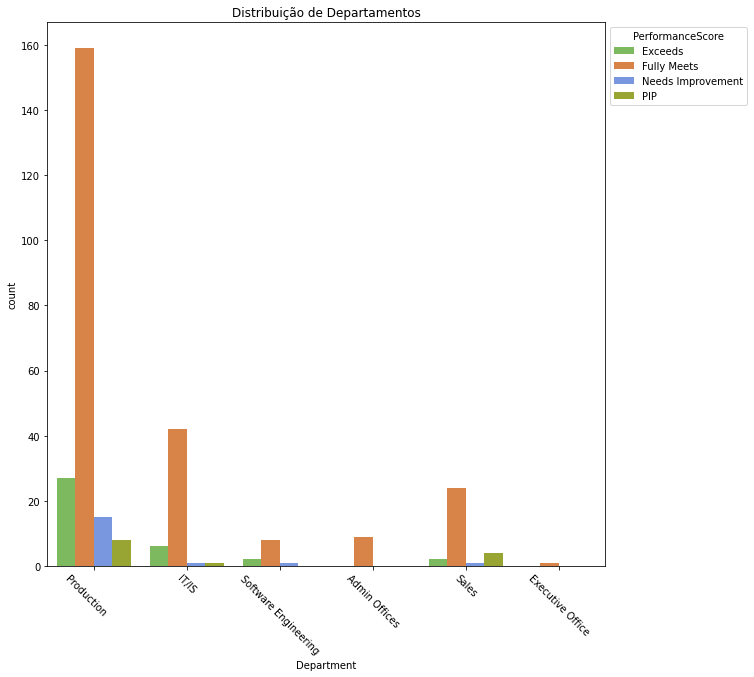

In [37]:
f, ax = plt.subplots(figsize=(10, 10))
color_types = ['#78C850','#F08030','#6890F0','#A8B820','#A8A878','#A040A0','#F8D030',  
                '#E0C068','#EE99AC','#C03028','#F85888','#B8A038','#705898','#98D8D8','#7038F8']
plt.xticks(rotation=-45)

sns.countplot(x='Department', hue='PerformanceScore', data=dfEngagementSurvey, palette=color_types).set_title('Distribuição de Departamentos')
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerformanceScore')

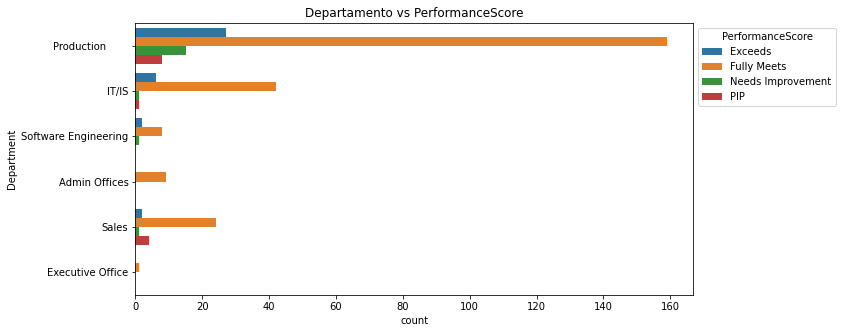

In [38]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(y="Department", hue='PerformanceScore', data=df).set_title('Departamento vs PerformanceScore');
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerformanceScore')

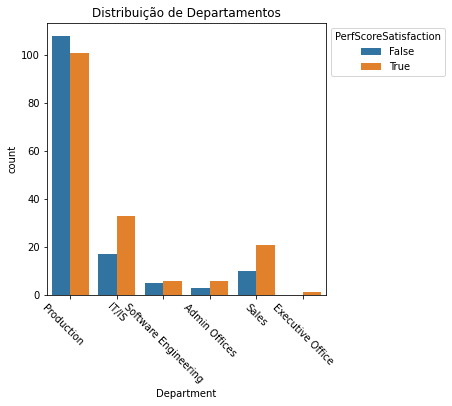

In [39]:
f, ax = plt.subplots(figsize=(5, 5))
plt.xticks(rotation=-45)

sns.countplot(x='Department', hue='PerfScoreSatisfaction', data=df).set_title('Distribuição de Departamentos')
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerfScoreSatisfaction')

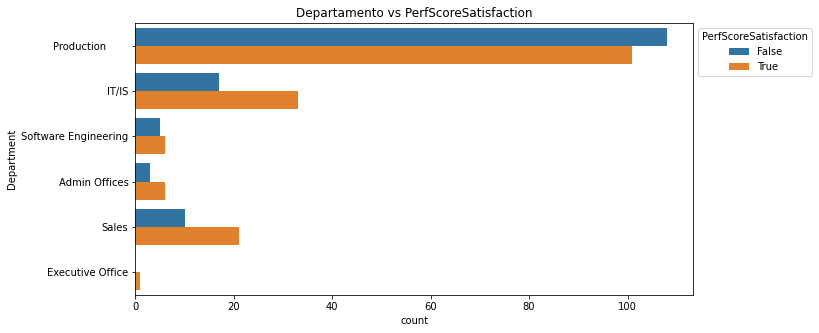

In [40]:
f, ax = plt.subplots(figsize=(10, 5))
sns.countplot(y="Department", hue='PerfScoreSatisfaction', data=df).set_title('Departamento vs PerfScoreSatisfaction');
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerfScoreSatisfaction')

## Department V.S. PerfScoreSatisfaction 
***
**Resumo:** Vamos ver mais informações sobre os departamentos da empresa.
 - Os departamentos de Produção, Técnico/Suporte e vendas são top 3 departamentos com maior quantidade de funcionários satisfação e performance.
 - O departamento de Produção é o mais representativo, e tem a taxa menor de satisfação e performance

**Questões:** 
 - Será que examinar em profundidade os departamentos que tem maior taxa de satisfação e performance e o menor pode nos revelar mais informações importantes?
 - Qual o salário nestes departamentos?

In [41]:
percentDepartmentPerfScoreSatisfaction = df.groupby(['Department', 'PerfScoreSatisfaction'])['PerfScoreSatisfaction'].count()
percentDepartmentPerfScoreSatisfaction = percentDepartmentPerfScoreSatisfaction / percentDepartmentPerfScoreSatisfaction.groupby(level=0).sum()
percentDepartmentPerfScoreSatisfaction
dfPercentDepartmentPerfScoreSatisfaction = pd.DataFrame()
for index, value in percentDepartmentPerfScoreSatisfaction.items():
    x = pd.DataFrame([[index[0], index[1], value]], columns=list(['Department', 'PerfScoreSatisfaction', 'Percent']))
    dfPercentDepartmentPerfScoreSatisfaction = pd.concat([dfPercentDepartmentPerfScoreSatisfaction, x], ignore_index=True)
dfPercentDepartmentPerfScoreSatisfaction

,Department,PerfScoreSatisfaction,Percent
0,Admin Offices,False,0.333333
1,Admin Offices,True,0.666667
2,Executive Office,True,1.000000
3,IT/IS,False,0.340000
4,IT/IS,True,0.660000
5,Production,False,0.516746
6,Production,True,0.483254
7,Sales,False,0.322581
8,Sales,True,0.677419
9,Software Engineering,False,0.454545


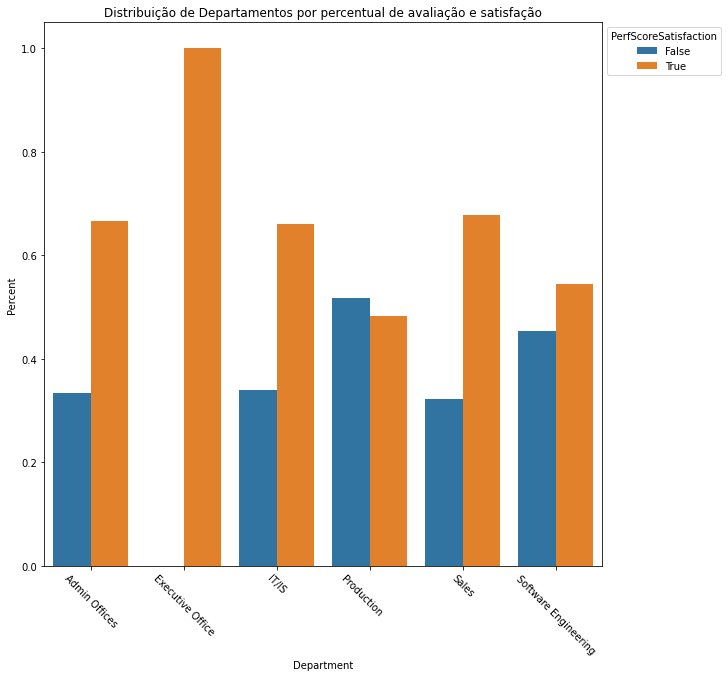

In [42]:
f, ax = plt.subplots(figsize=(10, 10))
plt.xticks(rotation=-45)

sns.barplot(x = 'Department', y = 'Percent', hue = 'PerfScoreSatisfaction', data = dfPercentDepartmentPerfScoreSatisfaction).set_title('Distribuição de Departamentos por percentual de avaliação e satisfação')
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerfScoreSatisfaction')

## Department V.S. porcentagem de avaliação e satisfação 
***
**Resumo:** Vamos ver mais informações sobre os departamentos da empresa.
 - O departamento de Prodição é o mais representativos, mas tem o menor indice dos mais satisfeitos e performance.
 - Os departamentos de Vendas, IT/IS e Administrativo são muito parecidos nas avaliações
 

#### Verificando o PerformanceScore em relação ao número de projetos.

[]

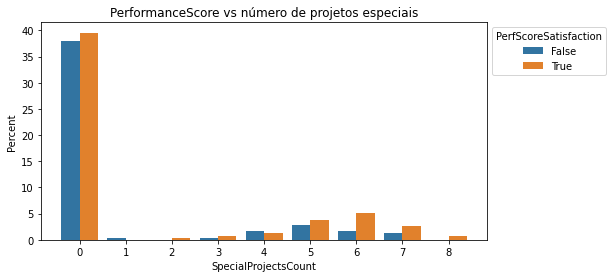

In [43]:
fig = plt.figure(figsize=(8,4),)
ax = sns.barplot(x="SpecialProjectsCount", y="SpecialProjectsCount", hue="PerfScoreSatisfaction", data=df, estimator=lambda x: len(x) / len(df) * 100)
ax.set(ylabel="Percent")
plt.title('PerformanceScore vs número de projetos especiais')
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerfScoreSatisfaction')
plt.plot()

In [44]:
countNoProjects = df[df.SpecialProjectsCount == 0].shape[0]
rateProjects = countNoProjects / len(df)
rateProjects

0.77491961414791

In [45]:
employeeProjects = df.groupby(["SpecialProjectsCount", "PerfScoreSatisfaction"])["PerfScoreSatisfaction"].count()
employeeProjects

SpecialProjectsCount  PerfScoreSatisfaction
0                     False                    118
                      True                     123
1                     False                      1
2                     True                       1
3                     False                      1
                      True                       2
4                     False                      5
                      True                       4
5                     False                      9
                      True                      12
6                     False                      5
                      True                      16
7                     False                      4
                      True                       8
8                     True                       2
Name: PerfScoreSatisfaction, dtype: int64

##  PerformanceScore V.S. ProjectCount 
***
**Resumo:** Insights interessantes que encontramos aqui:
 - 70% dos funcionários não participam de projetos especiais.
 - Dos que participam de projetos, 16 funcionários participam de 6 projetos especiais.
 - Existe uma pequena **tendência de crescimento no índice de satisfação e performace** em relação à quantidade de projetos. 
 
**Questões:**
 - Porque os funcionários ficam mais satisfeitos em relação a quantidade de projetos especiais?
 - Será que faz sentido pensar que funcionários envolvidos poucos projetos especiais estão desmotivados e por isso avaliam ruim a empresa?
 - Será que empregados envolvidos em mais projetos se sintam mais motivados?

#### Verificando o EngagementSurvey em relação a PerformanceScore.

In [46]:
df.groupby(["PerformanceScore"])["PerformanceScore"].count()

PerformanceScore
Exceeds               37
Fully Meets          243
Needs Improvement     18
PIP                   13
Name: PerformanceScore, dtype: int64

[]

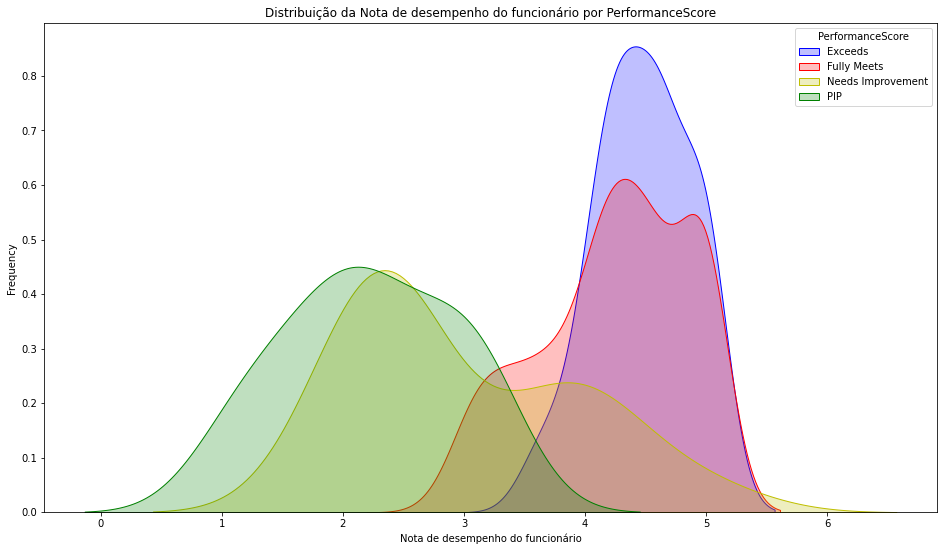

In [47]:
fig = plt.figure(figsize=(16,9))
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'Exceeds'),'EngagementSurvey'] , color='b',shade=True,label='Exceeds')
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'Fully Meets'),'EngagementSurvey'] , color='r',shade=True, label='Fully Meets')
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'Needs Improvement'),'EngagementSurvey'] , color='y',shade=True,label='Needs Improvement')
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'PIP'),'EngagementSurvey'] , color='g',shade=True, label='PIP')
ax.set(xlabel='Nota de desempenho do funcionário', ylabel='Frequency')
plt.title('Distribuição da Nota de desempenho do funcionário por PerformanceScore')
plt.legend(title = "PerformanceScore")
plt.plot()

## Performace V.S. Engajamento 
***
**Resumo:** 
 - temos uma distribuição dos peformace score baixa para os que são pouco engajados e alta para os que são engajados.
 - Funcionários com **baixa performance** tendem a ser menos engajados.
 - Funcionários com **alta performance** tendem a ser mais engajados.
 - O **ponto ideal** para os funcionários que foram mais engajados está dentro da performace acima de 4.

In [48]:
df.groupby(["PerfScoreSatisfaction", "Termd"])["Termd"].count()

PerfScoreSatisfaction  Termd
False                  0         39
                       1        104
True                   0        168
Name: Termd, dtype: int64

[]

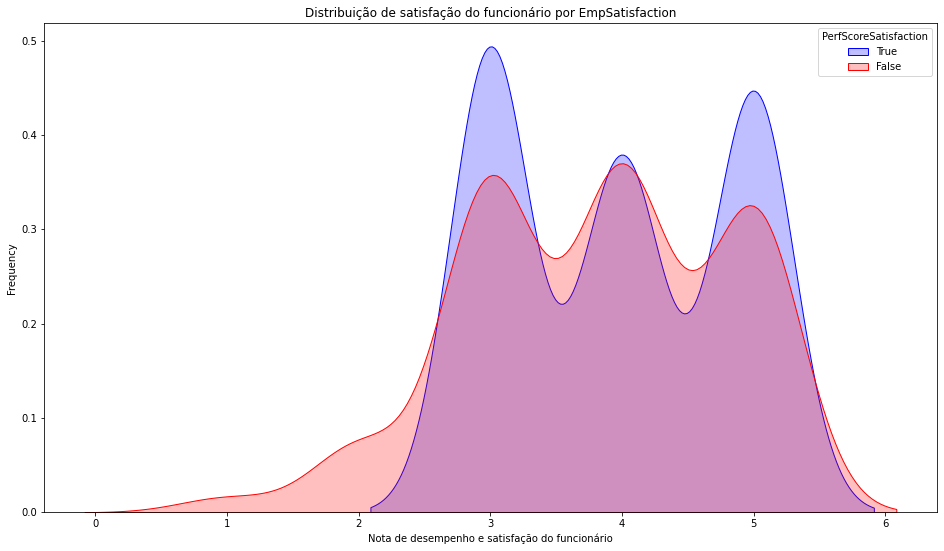

In [49]:
fig = plt.figure(figsize=(16,9))
ax=sns.kdeplot(df.loc[(df['PerfScoreSatisfaction'] == True),'EmpSatisfaction'] , color='b',shade=True,label='True')
ax=sns.kdeplot(df.loc[(df['PerfScoreSatisfaction'] == False),'EmpSatisfaction'] , color='r',shade=True, label='False')
ax.set(xlabel='Nota de desempenho e satisfação do funcionário', ylabel='Frequency')
plt.title('Distribuição de satisfação do funcionário por EmpSatisfaction')
plt.legend(title = "PerfScoreSatisfaction")
plt.plot() 

## PerfScoreSatisfaction V.S. EmpSatisfaction 
***
**Resumo:** 
 - Temos uma distribuição multimodal para o conjunto dos que possuem boa peformace e são engajados vs os de baixa performace e baixo engajamento.
 - Poucos estão abaixo do PerfScoreSatisfaction 3 e as distribuições são similares.
 - Há uma alta do PerfScoreSatisfaction em 3 e 5, sendo é igual para os dois grupos quando 4.

#### Verificando o PerformanceScore em relação a EmpSatisfaction do empregado.

In [51]:
df.groupby(["EmpSatisfaction"])["EmpSatisfaction"].count()

EmpSatisfaction
1      2
2      9
3    108
4     94
5     98
Name: EmpSatisfaction, dtype: int64

[]

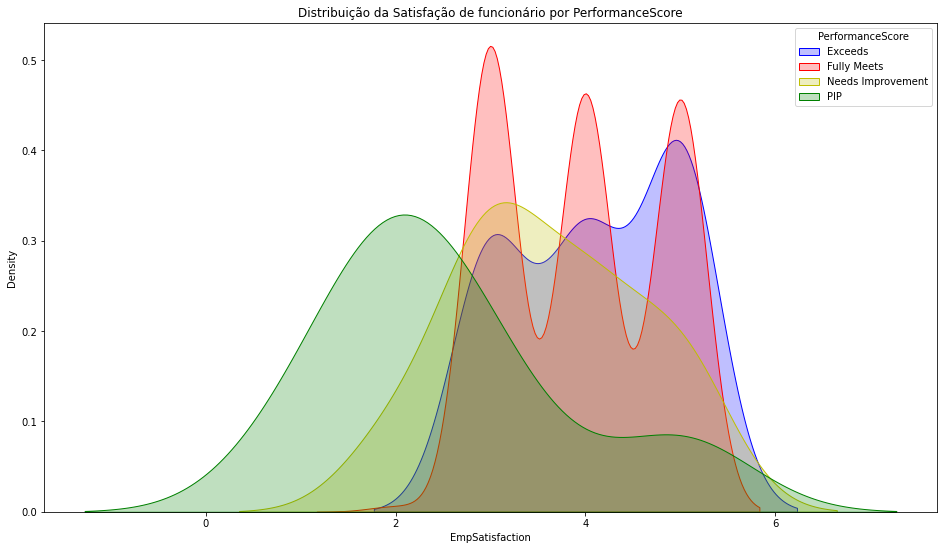

In [52]:
fig = plt.figure(figsize=(16,9))
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'Exceeds'),'EmpSatisfaction'] , color='b',shade=True, label='Exceeds')
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'Fully Meets'),'EmpSatisfaction'] , color='r',shade=True, label='Fully Meets')
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'Needs Improvement'),'EmpSatisfaction'] , color='y',shade=True, label='Needs Improvement')
ax=sns.kdeplot(df.loc[(df['PerformanceScore'] == 'PIP'),'EmpSatisfaction'] , color='g',shade=True, label='PIP')
plt.title('Distribuição da Satisfação de funcionário por PerformanceScore')
plt.legend(title = "PerformanceScore")
plt.plot()

##  PerformanceScore V.S. EmpSatisfaction 
***
**Resumo:** 
 - Funcionários com o nível de satisfação em 2 ou menos tendem a ter menos peformace.
 -  - Funcionários com o nível de satisfação acima de 3 tendem a ter mais peformace.
 com o nível de satisfação em 3 tem maior probabilidade de peformace.

#### Verificando a relação entre número de projetos especiais e a nota de avaliação do funcionário.

In [67]:
df.groupby(["PerformanceScore", "SpecialProjectsCount"])["EmpSatisfaction"].count()

PerformanceScore   SpecialProjectsCount
Exceeds            0                        29
                   3                         1
                   5                         5
                   6                         1
                   7                         1
Fully Meets        0                       185
                   2                         1
                   3                         2
                   4                         8
                   5                        16
                   6                        18
                   7                        11
                   8                         2
Needs Improvement  0                        16
                   4                         1
                   6                         1
PIP                0                        11
                   1                         1
                   6                         1
Name: EmpSatisfaction, dtype: int64

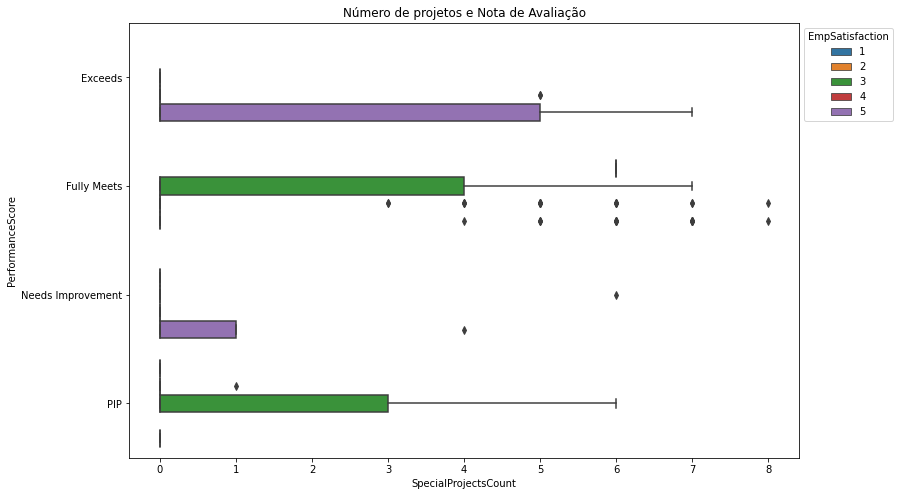

In [65]:
fig = plt.figure(figsize=(12, 8))
sns.boxplot(x="SpecialProjectsCount", y="PerformanceScore", hue="EmpSatisfaction", data=df)
plt.title("Número de projetos e Nota de Avaliação")
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'EmpSatisfaction')
plt.show()

##  SpecialProjectsCount VS PerformanceScore
***
**Resumo:** 
- Há um **aumento na satisfação** para os funcionários que realizaram mais projetos especiais dentro do grupo de quem foi avaliado como Exceeds. 
- Para o grupo de funcionários com satisfação mediana, tiveram uma **pontuação de peformace semelhante**, apesar do aumento da quantidade de projetos especiais.
- funcionários que tinham **dois projetos e uma péssima avaliação** saíram.
- funcionários com **menos de 3 projetos e avaliações baixas** não se consideravam insatisfeitos.
- nao tem uma tendencia forte
- tem outliers com peformace Fully meets com muitos projetos e satisfação media
- um valor pequeno de projetos para os de peformace Needs Improvement, porem com satisfação alta
- Os de peformace PIP com satisfacao média

**Questões:**
  - Por que os funcionários com peformace baixa estavam satisfeitos?
  - Da totalidade de funcionários, poucos os que participaram de projetos especiais, qual seria o motivo?

#### Verificando a relação entre a satisfação do empregado e a sua avaliação.

/Users/san/Documents/GitHub/Artigo_PUCRS_CD_IA/venv/lib/python3.8/site-packages/seaborn/regression.py:581: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


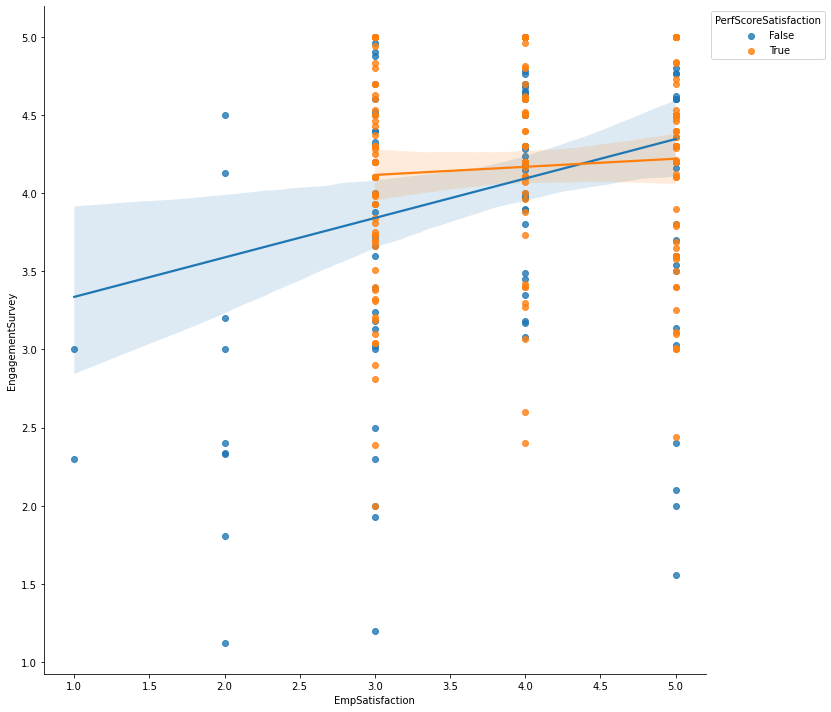

In [72]:
sns.lmplot(x = 'EmpSatisfaction', 
           y = 'EngagementSurvey', 
           data = df,
           hue='PerfScoreSatisfaction',
           legend=False,size=10)
plt.legend(loc = 2, bbox_to_anchor = (1,1), title = 'PerfScoreSatisfaction')

##  Satisfaction VS Engajamento
*** 
**Resumo:**: Temos aqui 2 grupos sutis de funcionários.
 
**Cluster 1 (funcionários com performace e satisfação baixa):** A satisfação abaixo de 3 e o engajamento inferior a 4 tendem a não satisfazer os requisitos de PerfScoreSatisfaction. O contrario tambem acontece nesse grupo, tem funcionários engajados e satisfeitos que não se encaixaram em PerfScoreSatisfaction.

Questões: 
 - Qual poderia ser o motivo de se sentir bem e ser altamente engajado e ter baixa peformace? 
 - Será que está trabalhando muito e está sobrecarregado? 
 
**Cluster 2 (funcionários bons e satisfeitos):** Satisfação acima de 3 e as suas avaliações acima de 3. 

Questões:
- Isso pode ser visto como funcionários que foram bem avaliados e se sentiram bem no trabalho.
- Podemos chamar esse grupo de alto desempenho?
- O que poderia significar que os funcionários neste grupo eram "ideais". 
- Eles gostam muito do seu trabalho e são altamente avaliados por seu desempenho.


#### Computando os clusters

#### Importando a biblioteca Scikit-learn

In [73]:
from sklearn.cluster import KMeans

#### Inicializando os clusters.

In [88]:
kmeans = KMeans(n_clusters=2,random_state=2)

#### Definindo o conjunto de dados.

vamos gerar um conjunto de dados apenas com o grupo de funcionarios com PerfScoreSatisfaction = True

In [110]:
dfPerfScoreSatisfaction = df[df.PerfScoreSatisfaction == True][["EmpSatisfaction","EngagementSurvey"]]

#### Computando os clusters.

In [111]:
kmeans.fit(dfPerfScoreSatisfaction)

KMeans(n_clusters=2, random_state=2)

In [112]:
kmeans_colors = ['red' if c == 0 else 'blue' for c in kmeans.labels_]

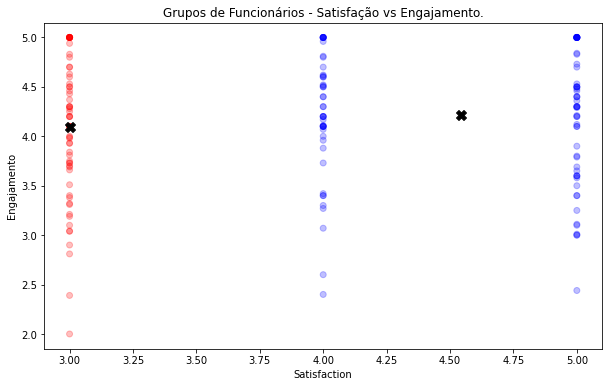

In [113]:
fig = plt.figure(figsize=(10, 6))
plt.scatter( x="EmpSatisfaction"
            ,y="EngagementSurvey"
            ,data=dfPerfScoreSatisfaction,
            alpha=0.25,color = kmeans_colors)

plt.xlabel("Satisfaction")
plt.ylabel("Engajamento")

plt.scatter( x=kmeans.cluster_centers_[:,0]
            ,y=kmeans.cluster_centers_[:,1]
            ,color="black"
            ,marker="X",s=100)

plt.title("Grupos de Funcionários - Satisfação vs Engajamento.")
plt.show()


## K-Means Grupos
***
**Cluster 0 (Azul):** Funcionários engajados e muito satisfeitos.

**Cluster 1 (Vermelho):** Funcionários que atendem as demandas e rasoavelmente insatisfeitos. 

#### Verificando a relação entre o tempo de empresa e o PerfScoreSatisfaction.

In [114]:
client.fget_object(
            "processing",
            "timeInCompany.parquet",
            "temp_.parquet",
)
dftimeInCompany = pd.read_parquet("temp_.parquet")
dftimeInCompany.head()

,DateofHire,Termd,DateofTermination,TimeInCompany
0,7/5/2011,0,None,8
1,3/30/2015,1,6/16/2016,2
2,7/5/2011,1,9/24/2012,2
3,1/7/2008,0,None,11
4,7/11/2011,1,9/6/2016,6


In [117]:
dftimeInCompany['PerfScoreSatisfaction'] = df[['PerfScoreSatisfaction']]
dftimeInCompany.head()

,DateofHire,Termd,DateofTermination,TimeInCompany,PerformanceScore,PerfScoreSatisfaction
0,7/5/2011,0,None,8,Exceeds,False
1,3/30/2015,1,6/16/2016,2,Fully Meets,False
2,7/5/2011,1,9/24/2012,2,Fully Meets,False
3,1/7/2008,0,None,11,Fully Meets,True
4,7/11/2011,1,9/6/2016,6,Fully Meets,False


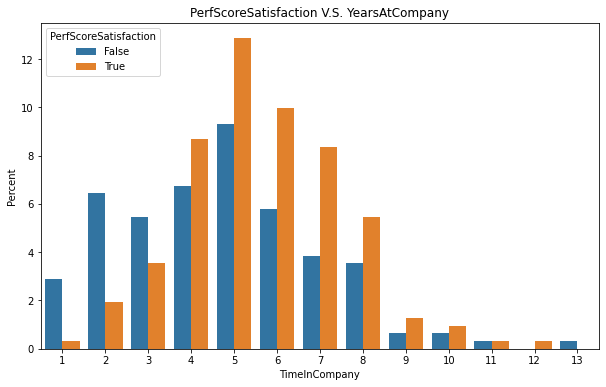

In [118]:
fig = plt.figure(figsize=(10, 6))
ax = sns.barplot(x="TimeInCompany", y="TimeInCompany", hue="PerfScoreSatisfaction", data=dftimeInCompany, estimator=lambda x: len(x) / len(dftimeInCompany) * 100)
ax.set(ylabel="Percent")
plt.title("PerfScoreSatisfaction V.S. YearsAtCompany")
plt.show()

##  PerfScoreSatisfaction V.S. YearsAtCompany 
***
**Resumo:** Vamos ver mais alguns pontos para entender o porque os funcionários serem satisfeitos e engajados.
 - funcionários com **5-8 anos de empresa** são mais engajados e satisfeitos.
 - nos 3 primeiros anos a maioria não consegue ter um grau de satisfação e engajamento satisfatório, após 4 anos o quadro inverte e aparecem como maioria os mais enganjados e satisfeitos chegando ao topo com 5 anos e a diferença se mantem até 7 anos, quando começa a se igualar entre os dois grupos.
 - funcionários abaixo de **4 anos e acima de 9 anos de empresa** devem ser analisados.
 
**Questões:**
  - Por que os funcionários não estão em um nivel bom de satisfação e engajamento no tempo de empresa de 1-4 e de 8-13 anos de empresa?
  - Quem são esses funcionários que não conseguem satisfação e engajamento?

### Carrega os artefatos para o Data Lake.

In [119]:
import joblib

#### Persistindo o objeto cluster para o disco.

In [120]:
joblib.dump(kmeans, "cluster.joblib")

['cluster.joblib']

#### Transferindo o arquivo para o Data Lake.

In [121]:
client.fput_object(
    "curated",
    "cluster.joblib",
    "cluster.joblib"
)

# Sweetviz

In [122]:
import sweetviz as sv

my_report = sv.analyze(df,"PerfScoreSatisfaction")
my_report.show_html()

                                             |          | [  0%]   00:00 -> (? left)

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
